**Meta Learning:** 

This is a key point of using ML-based models for forecasting: more often than not, ML models (especially deep learning models)  
need to be trained on large amounts of data, which often means a large amount of separate yet related time series.

We could think about getting more data by not combining the two series but instead use all the available series separately for training.

Also we could think of augmenting the time series by reversing it but i guess this is a bit of a stupid idea.

**Data Split:**  
Add a validation set to train the hyperparams.   
Usually these ratios are train/val/test: 60/20/20 but since we want to have some data after corona in training we have to change this. 

I will use 2657/225/225 days which is in ratio : 85.5/7.25/7.25. This means the traingset goes from 01.01.2015 till 10.04.2022. 


**Backtesting:**  
I should backtest the model to see how much overfitting is involved. This will really put the hyperparams to the test but requires retraining the model for each backtest.


**Ensembling:**  
If we have 3 good models, let's say prophet, linear regression and a ml base algo like randomforest, we could test if we gain something from ensembling them.

In [30]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt


#from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
from darts                             import TimeSeries
from darts.models                      import DLinearModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries


from pytorch_lightning.callbacks   import EarlyStopping
from darts.utils.likelihood_models import QuantileRegression
from torch.optim.lr_scheduler      import ReduceLROnPlateau
from torch.optim                   import Adam

from sklearn.metrics import mean_squared_error


In [17]:
def resample_fix_ends(pdf,frequency):
  """
  The function resamples the data according to the sampling frequency. 
  Often the first and the last data-point are deviating a lot from the rest of the series.
  
  As a simple fix i will just delete the first and the last value if they deviate more than 20% to their neighbour. 
  """

  pdf = pdf.resample(frequency).sum(min_count=1) #"D,W,M"

  for column in pdf.columns:
    if pdf[column].iloc[0] < 0.8*pdf[column].iloc[1]:
      pdf = pdf.drop(pdf.index[0]) 
      #pdf.at[pdf.index[0],column]   = pdf[column].iloc[1] #this would assigne the value of the next day to the first day.

    if pdf[column].iloc[-1] < 0.8*pdf[column].iloc[-2]:
      pdf = pdf.drop(pdf.index[-1]) 
      #pdf.at[pdf.index[-1],column]  = pdf[column].iloc[-2] #this would assigne the value of the second last day to the last day.

  return pdf

def reassign_outliers(pdf):
  """There is an extrem outlier in the data which is probably a mistake. I will reassign the value to it's neighbour."""

  for column in pdf.columns:
    
    outlier_loc = np.where(pdf[column] < np.mean(pdf[column])-3*np.std(pdf[column]))
    (pdf[column].values)[outlier_loc] = np.mean(pdf[column]) 

    print(f"Reassigned {len(outlier_loc)} values in the column {column}. These values where more than 3 sigma away from the mean.")

  return pdf


In [18]:
# url = "https://data.stadt-zuerich.ch/dataset/ewz_stromabgabe_netzebenen_stadt_zuerich/download/ewz_stromabgabe_netzebenen_stadt_zuerich.csv"
# pdf = pd.read_csv(url,index_col=None)


pdf = pd.read_csv("../data/ewz_stromabgabe_netzebenen_stadt_zuerich.csv",index_col=None)

pdf["Timestamp"] =  pd.to_datetime(pdf['Timestamp'],utc=True)
pdf = pdf.set_index(pdf["Timestamp"])
pdf = resample_fix_ends(pdf,"D")
pdf = reassign_outliers(pdf)

pdf.index = pdf.index.tz_localize(None)  #Let's drop the timezone info to avoid warnings

pdf["y"] = (pdf["Value_NE5"].values + pdf["Value_NE7"].values)/1e6 #in GWh
pdf = pdf.drop(columns=["Value_NE5","Value_NE7"])

#split data in train val and test
split = len(pdf)-450
pdf_train, pdf_val, pdf_test = pdf.iloc[:split], pdf.iloc[split:split+225], pdf.iloc[split+225:]

pdf

Reassigned 1 values in the column Value_NE5. These values where more than 3 sigma away from the mean.
Reassigned 1 values in the column Value_NE7. These values where more than 3 sigma away from the mean.


C:\Users\ewzbusi\AppData\Local\Temp\ipykernel_18604\3593820342.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pdf = pdf.resample(frequency).sum(min_count=1) #"D,W,M"


,y
Timestamp,
2015-01-01,6.709087
2015-01-02,7.073348
2015-01-03,7.149544
2015-01-04,6.724467
2015-01-05,8.585045
...,...
2023-06-30,7.247760
2023-07-01,6.168368
2023-07-02,5.750607


In [19]:
ytrain = TimeSeries.from_dataframe(pdf_train)
yval   = TimeSeries.from_dataframe(pdf_val)
ytest  = TimeSeries.from_dataframe(pdf_test)
ytotal = TimeSeries.from_dataframe(pdf)
ytotal


<TimeSeries (DataArray) (Timestamp: 3107, component: 1, sample: 1)>
array([[[6.70908714]],

       [[7.07334784]],

       [[7.14954415]],

       ...,

       [[5.75060674]],

       [[7.02940656]],

       [[6.82616489]]])
Coordinates:
  * Timestamp  (Timestamp) datetime64[ns] 2015-01-01 2015-01-02 ... 2023-07-04
  * component  (component) object 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [20]:
encoders = {"datetime_attribute": {"future": ["dayofweek","month", "year"]},"transformer": Scaler()}
#the transformer in the dict above is for the encoder and not for the data. 

In [21]:
model = DLinearModel(
                    input_chunk_length = 100,
                    output_chunk_length = 100,
                    add_encoders = encoders,
                    random_state=16
                    )

model.fit(series=ytrain,val_series=yval,epochs=50,verbose=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=50` reached.


DLinearModel(shared_weights=False, kernel_size=25, const_init=True, use_static_covariates=True, input_chunk_length=100, output_chunk_length=100, add_encoders={'datetime_attribute': {'future': ['dayofweek', 'month', 'year']}, 'transformer': Scaler}, random_state=16)

In [22]:
(past_covariates, future_covariates) = model.generate_fit_encodings(ytrain)
past_covariates

(16436.0, 16524.0)

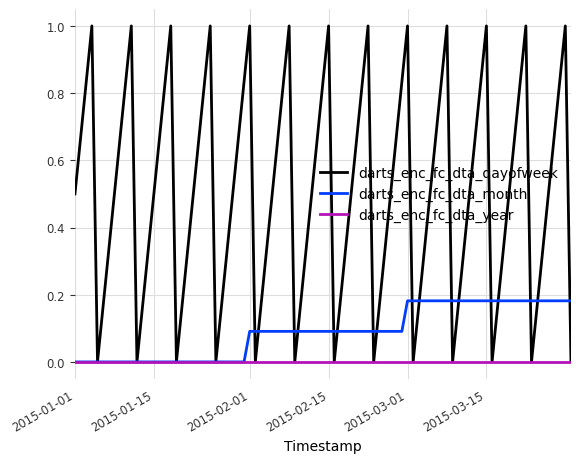

In [50]:
future_covariates.plot()
plt.xlim(pd.Timestamp("2015-01-01"), pd.Timestamp("2015-03-30"))

In [37]:
y_pred = model.predict(n=len(ytest), series=ytrain.append(yval)).pd_series()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

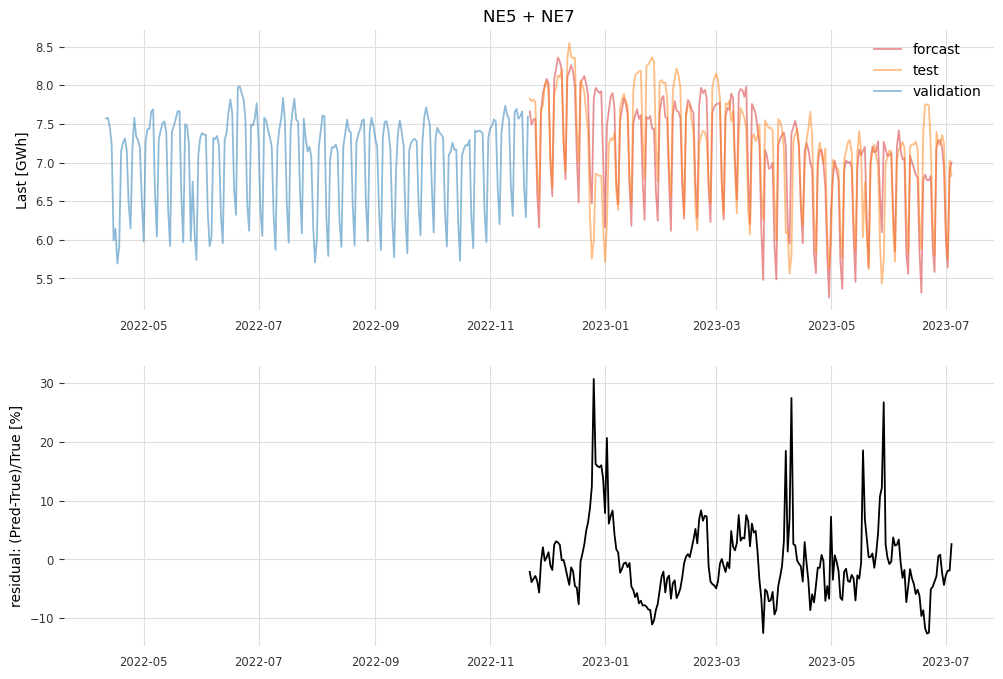

In [40]:
f, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(y_pred, color="tab:red", label="forcast", alpha=0.5)
# axes[0].plot(pdf_train[-2*365:], color="tab:blue", label="train")
axes[0].plot(pdf_test, color="tab:orange", label="test", alpha=0.5)
axes[0].plot(pdf_val, color="tab:blue", label="validation", alpha=0.5)
axes[0].legend()
axes[0].set_title("NE5 + NE7")
axes[0].set_ylabel("Last [GWh]")


xmin, xmax = axes[0].get_xlim()

axes[1].plot(pdf_test.index, (y_pred.values - pdf_test.y.values) / (pdf_test.y.values)*100)
axes[1].set_xlim(xmin, xmax)
axes[1].set_ylabel("residual: (Pred-True)/True [%]")

plt.show()

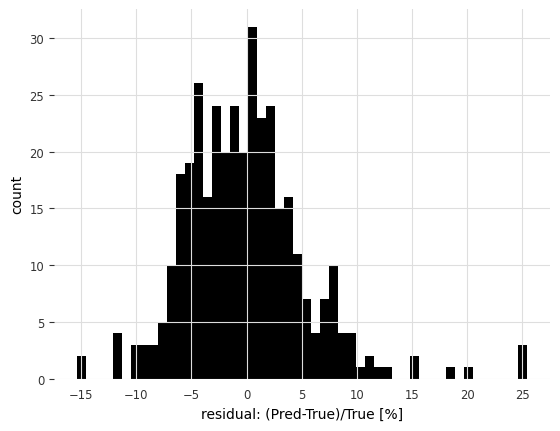

In [ ]:
#histogramm of the residuals

plt.hist((y_pred.values - pdf_test.y.values) / (pdf_test.y.values)*100, bins=50)
plt.xlabel("residual: (Pred-True)/True [%]")
plt.ylabel("count")
plt.show()

In [49]:
validation_prediction = model.predict(n=len(yval), series=ytrain).pd_series().values
rmse = mean_squared_error(pdf_val.y.values,validation_prediction, squared=False)
print(f"RMSE on validation set: {rmse:.3f}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

RMSE on validation set: 0.331


In [48]:
rmse = mean_squared_error(pdf_test.y.values, y_pred.values, squared=False)
print(f"RMSE on test set: {rmse:.3f}")


RMSE on test set: 0.449


#### Backtesting the model structure, requires the model parameters to be retrained